# Implementing a PINN to solve the Paraxial Helmholtz equation

### The Paraxial Helmholtz equation

The Paraxial Helmholtz equation (PHE) is given by

$$ \nabla_T^2 A(x,y,z) + 2ik \partial_z A(x,y,z) = 0, $$

where $\nabla_T^2$ is the transverse Laplacian.

We separate the PDE into real and imaginary part, where $A(x,y,z) := u(x,y,z) + i\cdot v(x,y,z)$:

\begin{align}
\frac{\partial^2 }{\partial x^2} &u(x,y,z) + \frac{\partial^2 }{\partial y^2} u(x,y,z) + 2k\partial_z v(x,y,z) \\
&+ i\cdot \left( \frac{\partial^2 }{\partial x^2} v(x,y,z) + \frac{\partial^2 }{\partial y^2} v(x,y,z) - 2k\partial_z u(x,y,z) \right) = 0
\end{align}

This leaves us with two coupled equations which will form the basis of our PINN:

\begin{align}
0 &=   \nabla_T^2  u(x,y,z) - 2k\partial_z v(x,y,z) \\
0 &=  \nabla_T^2  v(x,y,z) + 2k\partial_z u(x,y,z)
\end{align}

### Solution: The Gaussian wave

Our solution is the Gaussian wave:

$$ A(x,y,z) = \frac{A_0}{q(z)} \exp\left[ik(x^2+y^2) / (2q(z))\right] $$

with $q(z) = z - iz_0$. Again, we split into imaginary and real part according to $A(x,z) := u(x,z) + i\cdot v(x,z)$:

\begin{align}
A(x,y,z) &= \frac{A_0}{b} \exp[-R_0] \left(z \cos R - z_0 \sin R + i (z \sin R + z_0 \cos R)\right)
\end{align}

with

\begin{align}
b &:= z^2 + z_0^2 \\
R &:= kz\frac{x^2+y^2}{2b} \\
R_0 &:= kz_0 \frac{x^2+y^2}{2b} 
\end{align}

and receive

\begin{align}
u(x,y,z) &= \frac{A_0}{b} \exp[-R_0] \left(z \cos R - z_0 \sin R\right) \\
v(x,y,z) &= \frac{A_0}{b} \exp[-R_0] \left(z \sin R + z_0 \cos R\right)
\end{align}

#### Boundary conditions

We choose as boundaries $x,y \in [-1,1]$ and $z \in [-1,1]$, where we specify a solution for $z = 0$. This gives

\begin{align}
u(\pm 1, y, z) &\approx 0 \\
v(\pm 1, y, z) &\approx 0 
\end{align}

and

\begin{align}
u(x,\pm 1, z) &\approx 0  \\
v(x,\pm 1, z) &\approx 0 
\end{align}

and

\begin{align}
u(x,y,0) &= \frac{A_0}{z_0^2} \exp[-kz_0(y^2+x^2)/(2z_0^2)] \left(- z_0 \sin (k \cdot 0 \cdot (y^2+x^2)/(2z_0^2)) \right) = 0 \\
v(x,y,0) &= \frac{A_0}{z_0} \exp[-k(y^2+x^2)/(2z_0)]
\end{align}

#### Choosing the physical parameters

We choose $A_0 = 0.5$, $z_0 = 0.5$ and $k = 50$. The reason can be simply explained by plotting $u(x,y=0,z=0)$ (see a little later).

### Implementation - Hyperparameters

We use $4$ layers with $32$ nodes each.

# Code

### Importing stuff

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
from time import time

### Setting seed, backend and other setup conveniences

In [2]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [4]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

In [5]:
images = []  # container to store output images in order to create GIF

In [6]:
mpl.matplotlib_fname() # sanity check - where's my matplotlibrc

'/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')), '  yaay')

Num GPUs Available:  1   yaay


In [8]:
plt.style.use('./../rc.mplstyle')

In [9]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

### Setting physical constants

In [10]:
A_0 = 0.5
k = 50.
z_0 = 0.5

x_lb = -1.
x_ub = 1.

y_lb = -1.
y_ub = 1.

z_lb = -1.
z_ub = 1.

### Plotting the solution beforehand

In [11]:
def u_exact_np(x, y, z): # \frac{A_0}{b} \exp[-R_0] \left(z \cos R - z_0 \sin R\right)
    b = z_0**2 + z**2
    R_0 = k*z_0*(x**2 + y**2) / (2*b)
    R = k*z*(x**2 + y**2) / (2*b)
    return (A_0 / b) * np.exp(-R_0) * (z*np.cos(R) - z_0*np.sin(R))

def v_exact_np(x, y, z): # -\frac{A_0}{b} \exp[-R_0] \left(z \sin R + z_0 \cos R\right)
    b = z_0**2 + z**2
    R_0 = k*z_0*(x**2 + y**2) / (2*b)
    R = k*z*(x**2 + y**2) / (2*b)
    return (A_0 / b) * np.exp(-R_0) * (z*np.sin(R) + z_0*np.cos(R))

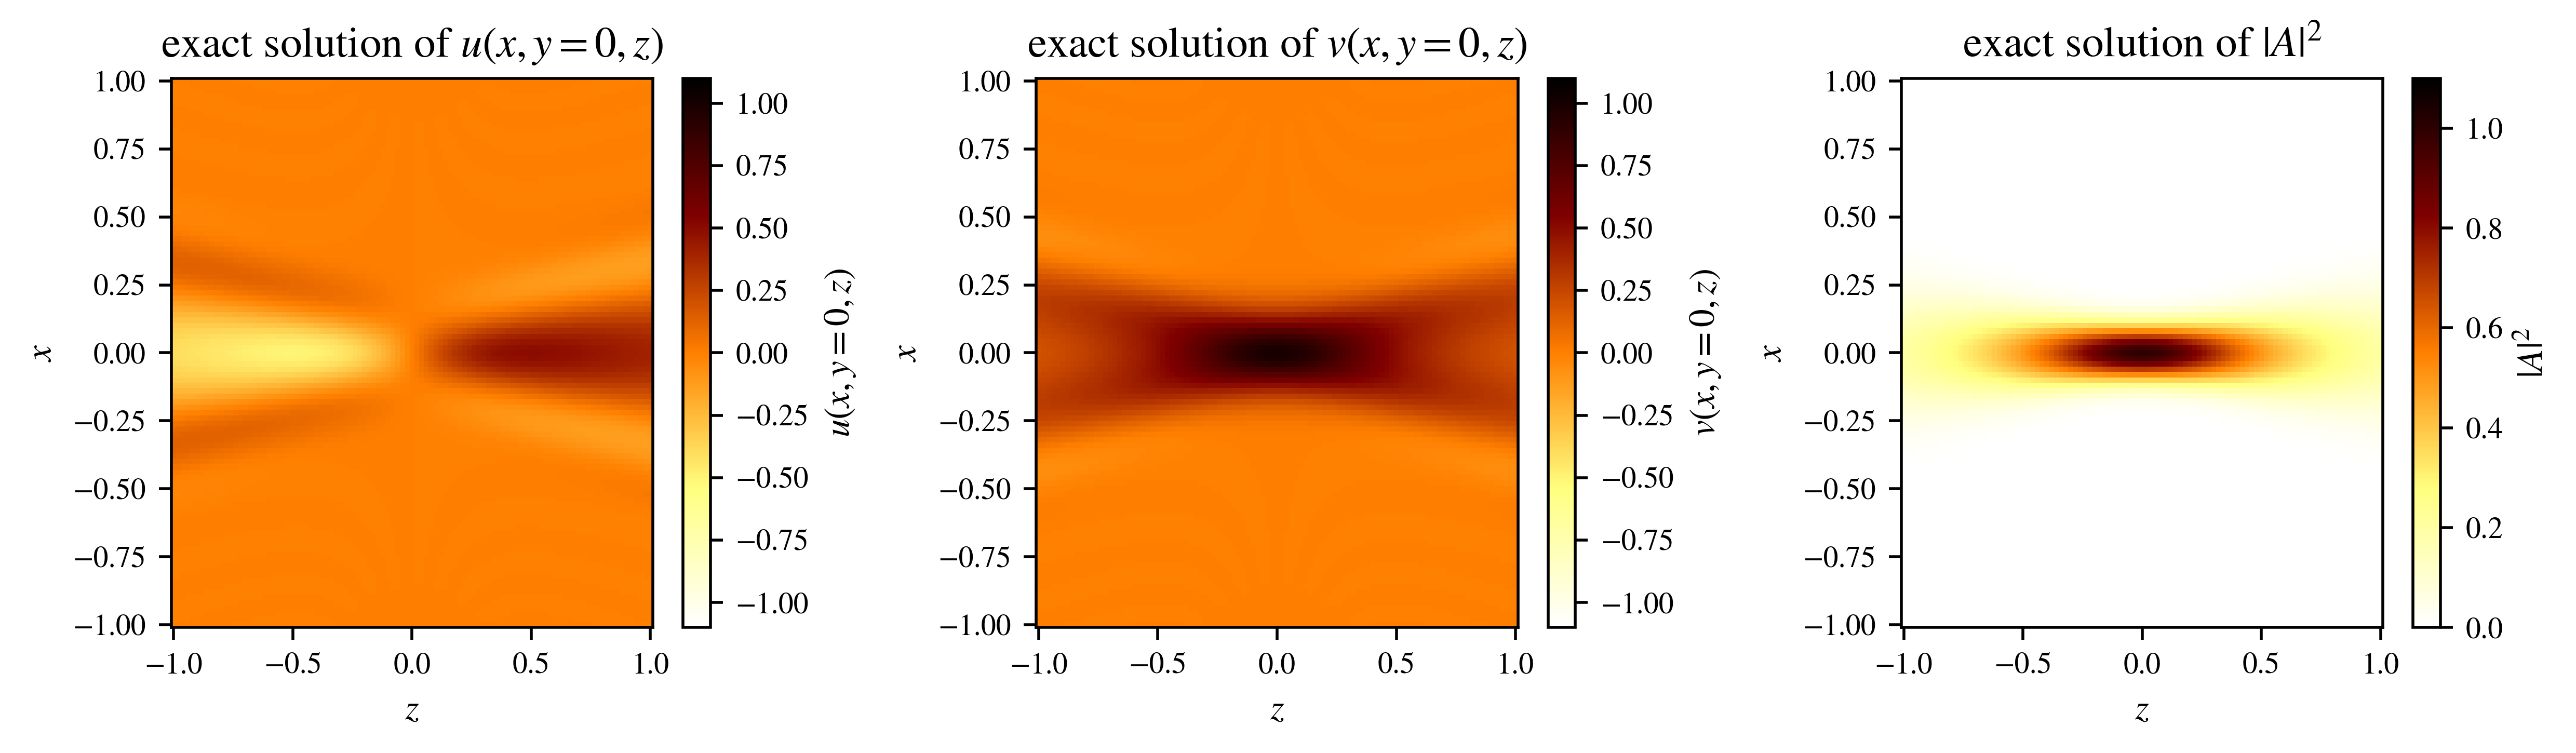

In [12]:
x_np = np.linspace(x_lb, y_ub, num=101)
y_np = np.linspace(y_lb, y_ub, num=101)
z_np = np.linspace(z_lb, z_ub, num=101)

x_npmesh2, y_npmesh2, z_npmesh2 = np.meshgrid(x_np, y_np, z_np)
x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3),dpi=500)

line1 = ax1.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,50,:], vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('exact solution of $u(x,y=0,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$u(x,y=0,z)$')

line2 = ax2.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,50,:], vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
ax2.set_xlabel('$z$')
ax2.set_ylabel('$x$')
ax2.set_title('exact solution of $v(x,y=0,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
cmap2.set_label('$v(x,y=0,z)$')

int_for_plot = ((u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,50,:])**2 + ((v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,50,:])**2

line3 = ax3.pcolormesh(z_npmesh2.T[:,:,0], x_npmesh2[:,:,0], int_for_plot, vmin=0, vmax=1.1, cmap = cm.afmhot_r)
ax3.set_xlabel('$z$')
ax3.set_ylabel('$x$')
ax3.set_title('exact solution of $|A|^2$')
cmap3 = fig.colorbar(line3, ax=ax3)
cmap3.set_label('$|A|^2$')

fig.tight_layout()

plt.show()

In [13]:
plt.close()

**The following just proofs that what I desire can be done way more easily** (but the complicated version might still be desired later on, so no regrets).

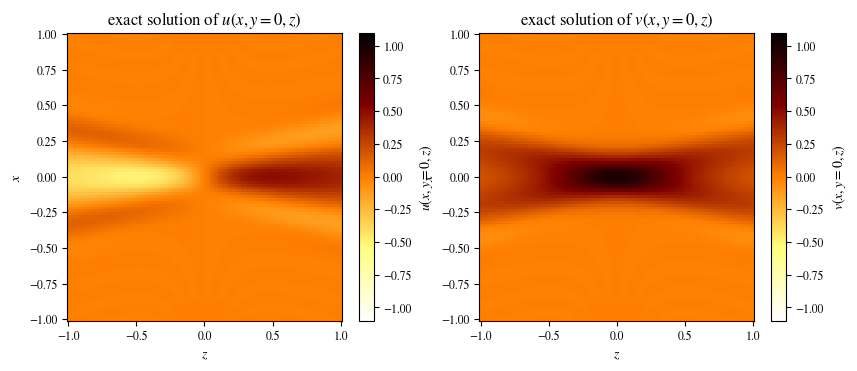

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

line1 = ax1.pcolormesh(z_npmesh, x_npmesh, (u_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,50,:], vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
ax1.set_xlabel('$z$')
ax1.set_ylabel('$x$')
ax1.set_title('exact solution of $u(x,y=0,z)$')
cmap1 = fig.colorbar(line1, ax=ax1)
cmap1.set_label('$u(x,y=0,z)$')

line2 = ax2.pcolormesh(z_npmesh, x_npmesh, (v_exact_np(x_npmesh2, y_npmesh2, z_npmesh2).T)[:,50,:], vmin=-1.1, vmax=1.1, cmap = cm.afmhot_r)
ax2.set_xlabel('$z$')
ax2.set_ylabel('$x$')
ax2.set_title('exact solution of $v(x,y=0,z)$')
cmap2 = fig.colorbar(line2, ax=ax2)
cmap2.set_label('$v(x,y=0,z)$')
plt.show()

In [15]:
plt.close()

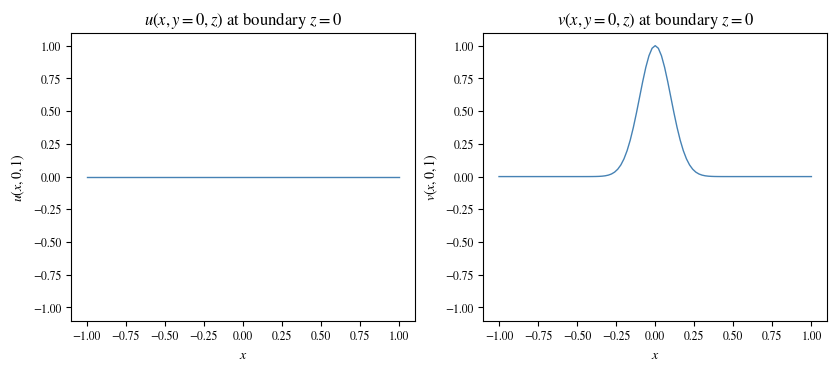

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

ax1.plot(x_npmesh[0,:], u_exact_np(x_npmesh, 0, z_npmesh)[50,:])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(x,0,1)$')
ax1.set_ylim(-1.1, 1.1)
ax1.set_title('$u(x,y=0,z)$ at boundary $z=0$')

ax2.plot(x_npmesh[0,:], v_exact_np(x_npmesh, 0, z_npmesh)[50,:])
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x,0,1)$')
ax2.set_ylim(-1.1, 1.1)
ax2.set_title('$v(x,y=0,z)$ at boundary $z=0$')

plt.show()

In [17]:
plt.close()

**This explains the choice of parameters in the beginning - for the first tries, we want to avoid too much complexity.** 

When the model works, we can increase $k$ in order to induce more oscillations.

### Determine neural network parameters

In [18]:
Nc = 10000  # collocation points
N_test = 101 # test points (will be done in a grid, so cubic)
N0 = 500 # initial conditions points
Nb = 500 # boundary points

### Create all input

In [19]:
# x and z collocation points for PDE residual

x = tf.random.uniform((Nc, 1), x_lb, x_ub, dtype=DTYPE)
y = tf.random.uniform((Nc, 1), y_lb, y_ub, dtype=DTYPE)
z = tf.random.uniform((Nc, 1), z_lb, z_ub, dtype=DTYPE)
XYZ = tf.concat([x, y, z], axis=1)

xtest = np.linspace(x_lb, x_ub, N_test)
ytest = np.linspace(y_lb, y_ub, N_test)
ztest = np.linspace(z_lb, z_ub, N_test)
xtestm_plot, ztestm_plot = np.meshgrid(xtest, ztest)
xtestm, ytestm, ztestm = np.meshgrid(xtest, ytest, ztest)
xtestm_resh = xtestm.flatten().reshape(N_test**3, 1)
ytestm_resh = ytestm.flatten().reshape(N_test**3, 1)
ztestm_resh = ztestm.flatten().reshape(N_test**3, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ytestm_resh_tf = tf.convert_to_tensor(ytestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XYZtest = tf.concat([xtestm_resh_tf, ytestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for z boundary condition
    # note that z = 1 in our case is like an initial condition
    # and is thus treated as such

z0 = tf.zeros((N0, 1), dtype=DTYPE)
x0 = tf.random.uniform((N0, 1), x_lb, x_ub, dtype=DTYPE)
y0 = tf.random.uniform((N0, 1), y_lb, y_ub, dtype=DTYPE)
XYZ0 = tf.concat([x0, y0, z0], axis=1)

# x, y and z for x boundary conditions

xb = tf.random.uniform((Nb, 1), x_lb, x_ub, dtype=DTYPE)
yb = tf.random.uniform((Nb, 1), y_lb, y_ub, dtype=DTYPE)
zb = tf.random.uniform((Nb, 1), z_lb, z_ub, dtype=DTYPE)

xlb = tf.ones((Nb, 1), dtype=DTYPE) * x_lb
XYZ_xlb = tf.concat([xlb, yb, zb], axis=1)
xub = tf.ones((Nb, 1), dtype=DTYPE) * x_ub
XYZ_xub = tf.concat([xub, yb, zb], axis=1)

ylb = tf.ones((Nb, 1), dtype=DTYPE) * y_lb
XYZ_ylb = tf.concat([xb, ylb, zb], axis=1)
yub = tf.ones((Nb, 1), dtype=DTYPE) * y_ub
XYZ_yub = tf.concat([xb, yub, zb], axis=1)

### Create all functions for tensorflow

\begin{align}
u(\pm 1, y, z) &\approx 0 \\
v(\pm 1, y, z) &\approx 0 
\end{align}


\begin{align}
u(x,\pm 1, z) &\approx 0  \\
v(x,\pm 1, z) &\approx 0 
\end{align}


\begin{align}
u(x,y,0) &= 0  \\
v(x,y,0) &= \frac{A_0}{z_0} \exp[-k(y^2+x^2)/(2z_0)]
\end{align}

In [20]:
# FUNCTION u

def u_init(x0,y0):
    return 0*x0 # just so it has the right dimensions

# FUNCTION v

def v_init(x0,y0):
    return (A_0 / z_0) * tf.exp(- k * (x0**2 + y0**2) / (2*z_0))

### Function to initialize model

In [21]:
def init_model(L = 4, N = 32):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(3))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'),
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

### Function to return the PDE residuals ("physics")

In [22]:
def physics(model, XYZ):
    with tf.GradientTape(persistent=True) as tape:
        x, y, z = XYZ[:, 0:1], XYZ[:, 1:2], XYZ[:, 2:3]
        
        tape.watch(x)
        tape.watch(y)
        tape.watch(z)
        
        A = model((tf.stack([x[:,0], y[:,0], z[:,0]], axis=1)))
        u = A[:, 0:1]
        v = A[:, 1:2]
        u_dx = tape.gradient(u, x)
        u_dy = tape.gradient(u, y)
        v_dx = tape.gradient(v, x)
        v_dy = tape.gradient(v, y)
        
    u_dz = tape.gradient(u, z)
    u_dx2 = tape.gradient(u_dx, x)
    u_dy2 = tape.gradient(u_dy, y)
    v_dz = tape.gradient(v, z)
    v_dx2 = tape.gradient(v_dx, x)
    v_dy2 = tape.gradient(v_dy, y)
    
    del tape
      
    real_resid = u_dx2 + u_dy2 - 2 * k * v_dz
    imag_resid = v_dx2 + v_dy2 + 2 * k * u_dz

    return real_resid, imag_resid

### Function to compute loss

In [23]:
def compute_loss(model, XYZ, XYZ0, XYZ_xlb, XYZ_xub, XYZ_ylb, XYZ_yub, phylr):
    real_resid, imag_resid = physics(model, XYZ)
    
    A_init_pred = model(XYZ0)
    A_xlb_pred  = model(XYZ_xlb)
    A_xub_pred  = model(XYZ_xub)
    A_ylb_pred  = model(XYZ_ylb)
    A_yub_pred  = model(XYZ_yub)
    
    u_init_pred = A_init_pred[:, 0:1]
    u_xlb_pred  = A_xlb_pred[:, 0:1]
    u_xub_pred  = A_xub_pred[:, 0:1]
    u_ylb_pred  = A_ylb_pred[:, 0:1]
    u_yub_pred  = A_yub_pred[:, 0:1]
 
    v_init_pred = A_init_pred[:, 1:2]
    v_xlb_pred  = A_xlb_pred[:, 1:2]
    v_xub_pred  = A_xub_pred[:, 1:2]
    v_ylb_pred  = A_ylb_pred[:, 1:2]
    v_yub_pred  = A_yub_pred[:, 1:2]
    
    u0_exact    = u_init(XYZ0[:,0:1], XYZ0[:,1:2])
    v0_exact    = v_init(XYZ0[:,0:1], XYZ0[:,1:2])
    
    real_phi_pde = tf.reduce_mean(tf.square(real_resid)) * phylr[0] * 10
    u_phi_xlb = tf.reduce_mean(tf.square(u_xlb_pred)) * phylr[1]
    u_phi_xub = tf.reduce_mean(tf.square(u_xub_pred)) * phylr[1]
    u_phi_ylb = tf.reduce_mean(tf.square(u_ylb_pred)) * phylr[1]
    u_phi_yub = tf.reduce_mean(tf.square(u_yub_pred)) * phylr[1]
    u_phi_i = tf.reduce_mean(tf.square(u0_exact - u_init_pred)) * phylr[2]
    
    imag_phi_pde = tf.reduce_mean(tf.square(imag_resid)) * phylr[0]
    v_phi_xlb = tf.reduce_mean(tf.square(v_xlb_pred)) * phylr[1]
    v_phi_xub = tf.reduce_mean(tf.square(v_xub_pred)) * phylr[1]
    v_phi_ylb = tf.reduce_mean(tf.square(v_ylb_pred)) * phylr[1]
    v_phi_yub = tf.reduce_mean(tf.square(v_yub_pred)) * phylr[1]
    v_phi_i = tf.reduce_mean(tf.square(v0_exact - v_init_pred)) * phylr[2]
    
    u_phi_bound = u_phi_xlb + u_phi_xub + u_phi_ylb + u_phi_yub
    v_phi_bound = v_phi_xlb + v_phi_xub + v_phi_ylb + v_phi_yub
    
    loss = real_phi_pde + imag_phi_pde + u_phi_bound + u_phi_i + v_phi_bound + v_phi_i
    
    # fucking hell I need a dictionary for that
    
    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

### Function to get gradients

In [24]:
def get_grad(model, XYZ, XYZ0, XYZ_xlb, XYZ_xub, XYZ_ylb, XYZ_yub, phylr = [5e-4, 1, 1]):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = compute_loss(model, XYZ, XYZ0, XYZ_xlb, XYZ_xub, XYZ_ylb, XYZ_yub, phylr)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, g

### Function to execute one full training step

In [25]:
#@tf.function
def trainstep():
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i, grad_theta = get_grad(model, XYZ, XYZ0, XYZ_xlb, XYZ_xub, XYZ_ylb, XYZ_yub)
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return  loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i

### Function to do plotting

In [26]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model(epoch):
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, int(N_test/2), :]
    v_plot = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)[:, int(N_test/2), :]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), dpi=500)
    line1 = ax1.pcolormesh(ztestm_plot, xtestm_plot, u_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,y=0,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    ax1.text(0.9, -0.9, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    line2 = ax2.pcolormesh(ztestm_plot, xtestm_plot, v_plot, cmap = cm.afmhot_r, vmin=-1.1, vmax=1.1)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,y=0,z)$')
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$x$')
    ax2.text(0.9, -0.9, str(epoch), fontsize=10,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    fig.subplots_adjust(wspace=0.25)
    fig.savefig(f'epochs/{epoch}.png')
    plt.close()

In [27]:
def save_discrete_model():
    A_plot = model(XYZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot_full = (u_plot_pre.numpy().reshape(N_test, N_test, N_test).T)
    v_plot_full = (v_plot_pre.numpy().reshape(N_test, N_test, N_test).T)
    
    u_plot = u_plot_full[:, int(N_test/2), :]
    v_plot = v_plot_full[:, int(N_test/2), :]
    
    np.savetxt('data/zmesh.txt', ztestm_plot)
    np.savetxt('data/xmesh.txt', xtestm_plot)
    np.save('data/ufull.npy', u_plot_full)
    np.save('data/vfull.npy', v_plot_full)
    np.savetxt('data/umesh.txt', u_plot)
    np.savetxt('data/vmesh.txt', v_plot)
    
    np.savetxt('data/loss.txt', np.array(loss_epoch))
    np.savetxt('data/loss_realpde.txt', np.array(real_physics_loss_epoch))
    np.savetxt('data/loss_imagpde.txt', np.array(imag_physics_loss_epoch))
    np.savetxt('data/loss_ubound.txt', np.array(u_bound_loss_epoch))
    np.savetxt('data/loss_vbound.txt', np.array(v_bound_loss_epoch))
    np.savetxt('data/loss_uinit.txt', np.array(u_initial_loss_epoch))
    np.savetxt('data/loss_vinit.txt', np.array(v_initial_loss_epoch))


### Initialize model, create boundaries, choose optimizer

In [28]:
model = init_model()
#boundaries, values = [1000, 3000,10000], [5e-3, 5e-3, 5e-3, 1e-3]
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4) #### TILL 25000: 1e-3, AFTER 25000: 5e-4

### Do some setup before the loop

In [29]:
epoch = 0
loss = 1.
t0 = time()

maxepoch = 40000
loss_epoch = []
real_physics_loss_epoch = []
u_bound_loss_epoch = []
u_initial_loss_epoch = []
imag_physics_loss_epoch = []
v_bound_loss_epoch = []
v_initial_loss_epoch = []
phylr = [1e-3, 1, 1]

### Interrupted Training? No problem! Here it continues

In [30]:
model.load_weights('weights/pinn_weights_trained')
epoch = 25000

### The loop

In [31]:
while loss > 1e-5 and epoch < maxepoch:
    loss, real_phi_pde, imag_phi_pde, u_phi_bound, u_phi_i, v_phi_bound, v_phi_i = trainstep()
    loss_epoch.append(loss)
    real_physics_loss_epoch.append(real_phi_pde)
    u_bound_loss_epoch.append(u_phi_bound)
    u_initial_loss_epoch.append(u_phi_i)
    imag_physics_loss_epoch.append(imag_phi_pde)
    v_bound_loss_epoch.append(v_phi_bound)
    v_initial_loss_epoch.append(v_phi_i)
    
    if epoch % 100 == 0:
        plot_model(epoch)
        print(f'Elapsed time: {time()-t0:.0f} s')
        print(f'  Currently on iteration {epoch}')
        print(f'  Loss: {loss:.6f} with real loss {real_phi_pde:.6f}, imaginary loss {imag_phi_pde:.6f}')
        print(f'    and u bound loss {u_phi_bound:.6f}, u init loss {u_phi_i:.6f}')    
        print(f'    and v bound loss {v_phi_bound:.6f}, v init loss {v_phi_i:.6f}')
        if epoch % 1000 == 0:
            model.save_weights(f'weights/pinn_weights_{epoch}')
    epoch += 1

Elapsed time: 2 s
  Currently on iteration 25000
  Loss: 0.000692 with real loss 0.000095, imaginary loss 0.000199
    and u bound loss 0.000011, u init loss 0.000006
    and v bound loss 0.000011, v init loss 0.000371
Elapsed time: 14 s
  Currently on iteration 25100
  Loss: 0.000671 with real loss 0.000092, imaginary loss 0.000199
    and u bound loss 0.000005, u init loss 0.000004
    and v bound loss 0.000003, v init loss 0.000369
Elapsed time: 27 s
  Currently on iteration 25200
  Loss: 0.000668 with real loss 0.000092, imaginary loss 0.000199
    and u bound loss 0.000005, u init loss 0.000004
    and v bound loss 0.000002, v init loss 0.000367
Elapsed time: 41 s
  Currently on iteration 25300
  Loss: 0.000666 with real loss 0.000092, imaginary loss 0.000199
    and u bound loss 0.000005, u init loss 0.000004
    and v bound loss 0.000002, v init loss 0.000364
Elapsed time: 54 s
  Currently on iteration 25400
  Loss: 0.000664 with real loss 0.000092, imaginary loss 0.000198
    a

Elapsed time: 411 s
  Currently on iteration 28000
  Loss: 0.000579 with real loss 0.000082, imaginary loss 0.000181
    and u bound loss 0.000005, u init loss 0.000003
    and v bound loss 0.000002, v init loss 0.000306
Elapsed time: 425 s
  Currently on iteration 28100
  Loss: 0.000596 with real loss 0.000083, imaginary loss 0.000181
    and u bound loss 0.000014, u init loss 0.000005
    and v bound loss 0.000008, v init loss 0.000305
Elapsed time: 441 s
  Currently on iteration 28200
  Loss: 0.000577 with real loss 0.000084, imaginary loss 0.000180
    and u bound loss 0.000005, u init loss 0.000003
    and v bound loss 0.000002, v init loss 0.000302
Elapsed time: 454 s
  Currently on iteration 28300
  Loss: 0.000572 with real loss 0.000081, imaginary loss 0.000179
    and u bound loss 0.000005, u init loss 0.000004
    and v bound loss 0.000003, v init loss 0.000300
Elapsed time: 468 s
  Currently on iteration 28400
  Loss: 0.000583 with real loss 0.000084, imaginary loss 0.000179

Elapsed time: 943 s
  Currently on iteration 31800
  Loss: 0.000488 with real loss 0.000069, imaginary loss 0.000162
    and u bound loss 0.000004, u init loss 0.000003
    and v bound loss 0.000002, v init loss 0.000247
Elapsed time: 957 s
  Currently on iteration 31900
  Loss: 0.000485 with real loss 0.000069, imaginary loss 0.000162
    and u bound loss 0.000004, u init loss 0.000003
    and v bound loss 0.000002, v init loss 0.000246
Elapsed time: 971 s
  Currently on iteration 32000
  Loss: 0.000483 with real loss 0.000068, imaginary loss 0.000161
    and u bound loss 0.000004, u init loss 0.000003
    and v bound loss 0.000002, v init loss 0.000245
Elapsed time: 985 s
  Currently on iteration 32100
  Loss: 0.000542 with real loss 0.000120, imaginary loss 0.000161
    and u bound loss 0.000006, u init loss 0.000003
    and v bound loss 0.000007, v init loss 0.000245
Elapsed time: 999 s
  Currently on iteration 32200
  Loss: 0.000580 with real loss 0.000081, imaginary loss 0.000161

Elapsed time: 1469 s
  Currently on iteration 35500
  Loss: 0.000432 with real loss 0.000062, imaginary loss 0.000149
    and u bound loss 0.000003, u init loss 0.000002
    and v bound loss 0.000002, v init loss 0.000213
Elapsed time: 1483 s
  Currently on iteration 35600
  Loss: 0.000438 with real loss 0.000061, imaginary loss 0.000149
    and u bound loss 0.000006, u init loss 0.000003
    and v bound loss 0.000006, v init loss 0.000213
Elapsed time: 1497 s
  Currently on iteration 35700
  Loss: 0.000523 with real loss 0.000123, imaginary loss 0.000149
    and u bound loss 0.000006, u init loss 0.000003
    and v bound loss 0.000026, v init loss 0.000217
Elapsed time: 1511 s
  Currently on iteration 35800
  Loss: 0.000427 with real loss 0.000061, imaginary loss 0.000148
    and u bound loss 0.000004, u init loss 0.000003
    and v bound loss 0.000001, v init loss 0.000210
Elapsed time: 1525 s
  Currently on iteration 35900
  Loss: 0.000423 with real loss 0.000060, imaginary loss 0.0

Elapsed time: 1996 s
  Currently on iteration 39200
  Loss: 0.000391 with real loss 0.000055, imaginary loss 0.000138
    and u bound loss 0.000005, u init loss 0.000003
    and v bound loss 0.000002, v init loss 0.000189
Elapsed time: 2012 s
  Currently on iteration 39300
  Loss: 0.000386 with real loss 0.000054, imaginary loss 0.000137
    and u bound loss 0.000003, u init loss 0.000002
    and v bound loss 0.000001, v init loss 0.000188
Elapsed time: 2026 s
  Currently on iteration 39400
  Loss: 0.000385 with real loss 0.000054, imaginary loss 0.000137
    and u bound loss 0.000003, u init loss 0.000002
    and v bound loss 0.000001, v init loss 0.000187
Elapsed time: 2040 s
  Currently on iteration 39500
  Loss: 0.000384 with real loss 0.000054, imaginary loss 0.000137
    and u bound loss 0.000003, u init loss 0.000002
    and v bound loss 0.000001, v init loss 0.000187
Elapsed time: 2054 s
  Currently on iteration 39600
  Loss: 0.000383 with real loss 0.000054, imaginary loss 0.0

In [32]:
model.save_weights('weights/pinn_weights_trained')
plot_model(epoch)

In [33]:
print(f'Elapsed time: {time()-t0:.0f} s')
print(f'  Currently on iteration {epoch}')
print(f'  Loss: {loss:.6f} with real loss {real_phi_pde:.6f}, imaginary loss {imag_phi_pde:.6f}')
print(f'    and u bound loss {u_phi_bound:.6f}, u init loss {u_phi_i:.6f}')    
print(f'    and v bound loss {v_phi_bound:.6f}, v init loss {v_phi_i:.6f}')

Elapsed time: 2111 s
  Currently on iteration 40000
  Loss: 0.000382 with real loss 0.000054, imaginary loss 0.000136
    and u bound loss 0.000004, u init loss 0.000002
    and v bound loss 0.000003, v init loss 0.000184


### Plotting of results

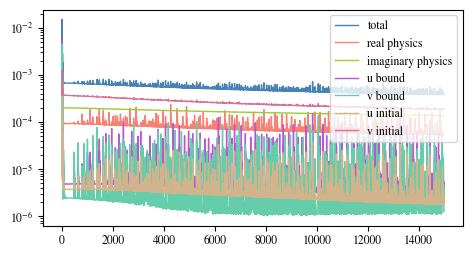

In [34]:
fig, ax = plt.subplots(1)
ax.set_yscale('log')
ax.plot(loss_epoch, label='total')
ax.plot(real_physics_loss_epoch, label='real physics')
ax.plot(imag_physics_loss_epoch, label='imaginary physics')
ax.plot(u_bound_loss_epoch, label='u bound')
ax.plot(v_bound_loss_epoch, label='v bound')
ax.plot(u_initial_loss_epoch, label='u initial')
ax.plot(v_initial_loss_epoch, label='v initial')
#plt.ylim(0, 0.001)
ax.legend(loc='upper right')
plt.show()

In [35]:
plt.close()

### Testing ground

In [36]:
#for i in range(maxepoch):
#    if i % 100:
#        images.append(imageio.imread(f'epochs/{i}.png'))
#imageio.mimsave('diffraction3D.gif',images,fps=20)

<img src="diffraction3D_newbound.gif?5" width="750" align="center">

# Checklist of bugfixing

### check physics

- [x] PDEs correct?
- [x] implementation correct?

### check code

- [x] plotting correct?
- [x] check every damn line of code (yay)

### does it work?

- [x] yes

In [37]:
#save_discrete_model()